In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch

import programs.conditions as cnd
import programs.NN as NN
import programs.visualize as vis
import programs.solvers as solv

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Gap width
w = 1

# Proppant viscosity
mu0 = 1

# Maximum proppant concentration
cmax = 1

# Influent proppant concentration
cin = 0.5

# Incoming flow rate
v_x_inlet = -0.025

# Mixture flow
Q0 = -v_x_inlet*w

# Length of permeable area
chi = 0.4

# Width
H = 1

# Length
L = 1

# Number of randomly generated points for IC and BC
cond_points = 32

# Bounds for t,x,y
x_min, x_max, y_min, y_max, t_min, t_max = 0, L, 0, H, 0, 10
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Coordinates for IC and BC
x_range, y_range, t_range = np.linspace(x_min, x_max, cond_points), torch.linspace(y_min, y_max, cond_points), np.linspace(t_min, t_max, cond_points)
ranges = [x_range, y_range, t_range]

# Number of collocation points
collocation = 32

# Function describing the distribution of mixture flow along the perforation interval
# psi = np.where(np.abs(y_range - np.max(y_range) / 2) <= chi / 2, 1 / chi, 0)
# psi = torch.FloatTensor(psi).to(device)

zeros = torch.zeros(cond_points).to(device)
ones = torch.ones(cond_points).to(device)

c_condition = [[0, 0, 0, cin * chi], [1, 1, 0, 0], [False, False, False, True]]
cond = 12 * mu0 * Q0 / w**3
p_condition = [[0, 0, cond, cond], [1, 1, 1, 1], [False, False, True, True]]
print (cond/chi, collocation**3)

0.7500000000000001 32768


In [62]:
net = NN.Poisson_Convection(w=w, mu0=mu0, cmax=cmax, v_in=v_x_inlet, chi=chi, size=boundaries,
                            c_cond=c_condition, p_cond=p_condition, collocation=collocation, cond_points=cond_points)

In [63]:
# net.full_save("data/wtf10","data/wtf10d")
net.full_load("data/wtf8","data/wtf8d.npy")
# net.full_load("data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05","data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05_data.npy")

In [73]:
weights = [1,1000000,100,1]
net.weights = weights/np.max(weights)
net.Adam_epochs = 1500
net.train()
# net.full_save("data/vx=0.025chi=0.4hmm2","data/vx=0.025chi=0.4hmm2d")
# parameters = {'v_in':[0.05, 0.1, 0.2, 0.5, 1]}
# net.CL_train(constants=parameters)
# net.full_save("data/vx=0.05chi=0.4","data/vx=0.05chi=0.4d")

|       Epochs        |           PDE loss            |            IC loss            |            BC loss            |         Summary loss          |
|        1010         |    1.0726846994657535e-05     |     6.27797263064167e-08      |     4.446356797416229e-06     |    1.5235983482853044e-05     |
|        1020         |    2.6019602046289947e-06     |      6.9741906827403e-07      |    5.0377275329083204e-06     |     8.337106919498183e-06     |
|        1030         |     1.019744331642869e-06     |     1.551156287860067e-07     |     4.82004497825983e-06      |      5.9949052229058e-06      |
|        1040         |     8.076533504208783e-07     |     1.91138251892653e-08      |      4.5704086915066e-06      |     5.397175755206263e-06     |
|        1050         |     7.512842330470448e-07     |    1.5473929693143873e-08     |     4.457892828213517e-06     |     5.224650976742851e-06     |
|        1060         |     5.153617621544981e-07     |    2.1022790619440457e-08     | 

3.227001343475422e-06 17258


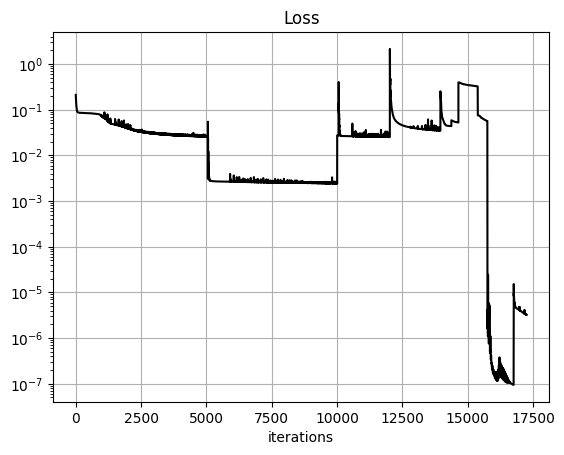

In [74]:
print (net.losses[-1], len(net.losses))
plt.semilogy(net.losses, c='black')
plt.title('Loss')
plt.xlabel('iterations')
plt.grid()
# plt.ylim(0,1)

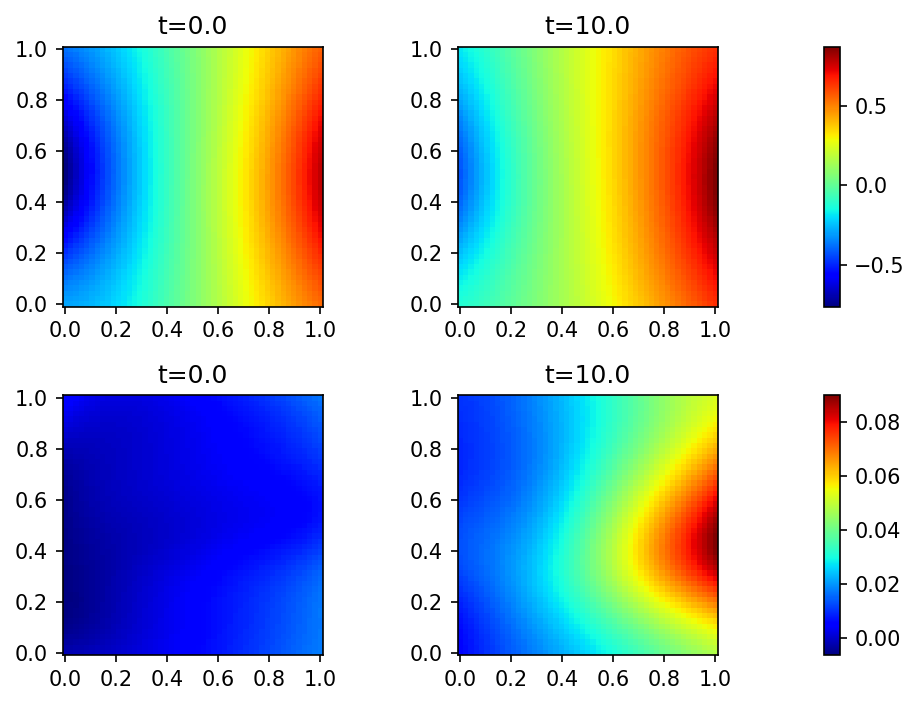

In [75]:
Nx = 49
Ny = 49
net.model.eval()
outputs = vis.plot_results(x_min, x_max, y_min, y_max, t_max, net.model, Nx, Ny)#, clims=[0,0.6,0,0.5])

In [67]:
# Q = 0.5*w
solver = solv.Solver(mu0, cmax, cin, chi, Q0, w, H, L, Nx, Ny)
solver.load(['solve/c0.02504.npy','solve/p0.02504.npy','solve/t0.02504.npy'])

In [68]:
# solver.Transport_Solver(10)
# solver.save(['solve/c0.02504.npy','solve/p0.02504.npy','solve/t0.02504.npy'])

0.7500000000000001


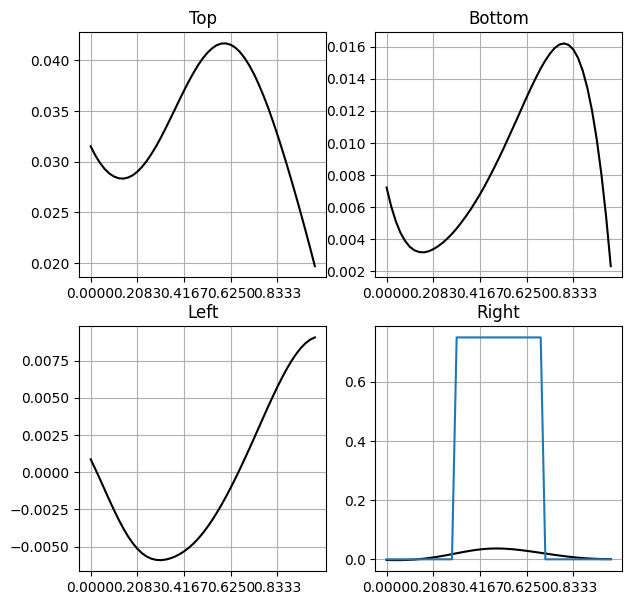

In [69]:
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)
X, Y = np.meshgrid(x,y)
K = 200
p_analitical = cnd.Poisson_analytical(mu=mu0, Q0=Q0, w=w, x=X, y=Y, chi=chi, H=H, L=L, K=K)
vis.plot_BC(outputs[3], x, y, L/(Nx-1), H/(Ny-1), [1,1,0,0])
print (np.max(cond/chi))
plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, 0.75, 0))
# plt.plot(x,outputs[2][:,-1])
# print ((L/(Nx-1)))

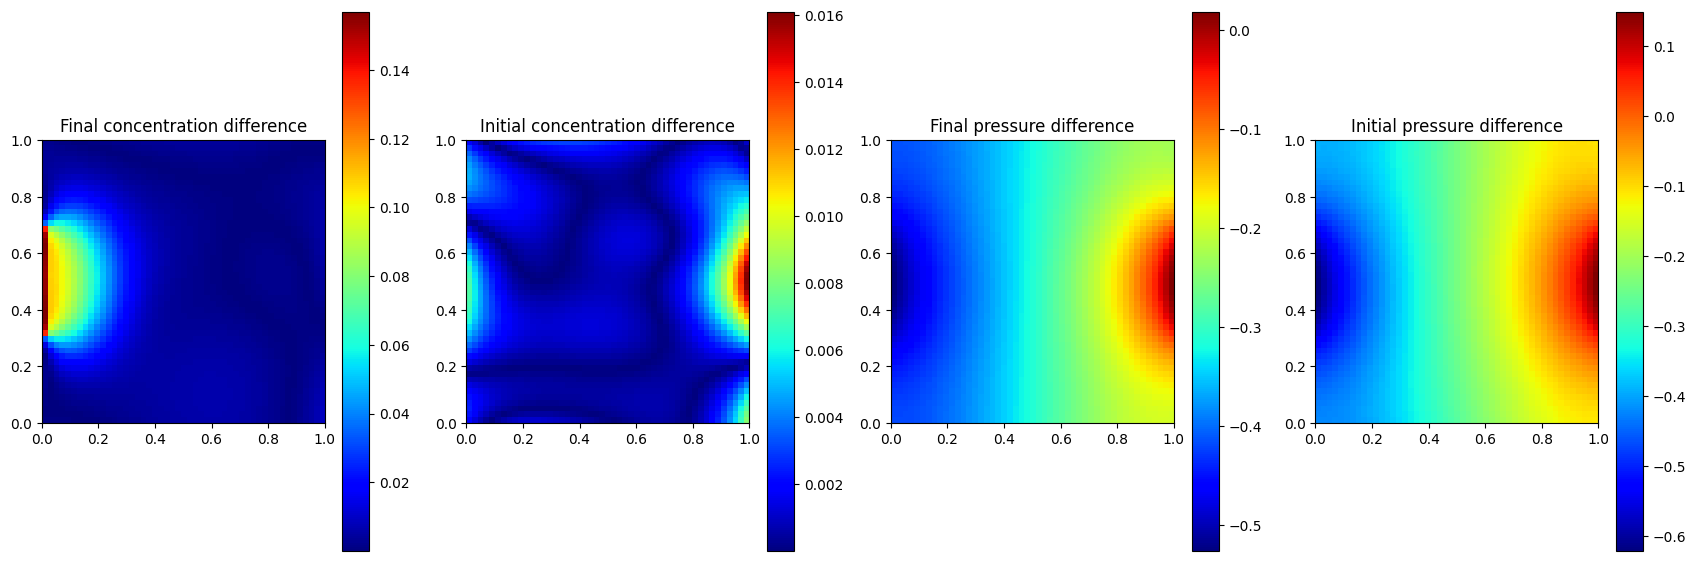

In [70]:
fig = plt.figure(figsize=(21,7))
plt.subplot(141)
vis.plot(np.abs(solver.c[-1][1:-1, 1:-1] - outputs[3][:,::-1]), [x_min,x_max,y_min,y_max], 'Final concentration difference')
plt.subplot(142)
vis.plot(np.abs(solver.c[0][1:-1, 1:-1] - outputs[2][:,::-1]), [x_min,x_max,y_min,y_max], 'Initial concentration difference')
plt.subplot(143)
vis.plot((solver.p[-1][1:-1, 1:-1] - outputs[1][:,::-1]), [x_min,x_max,y_min,y_max], 'Final pressure difference')
plt.subplot(144)
vis.plot((solver.p[0][1:-1, 1:-1] - outputs[0][:,::-1]), [x_min,x_max,y_min,y_max], "Initial pressure difference")

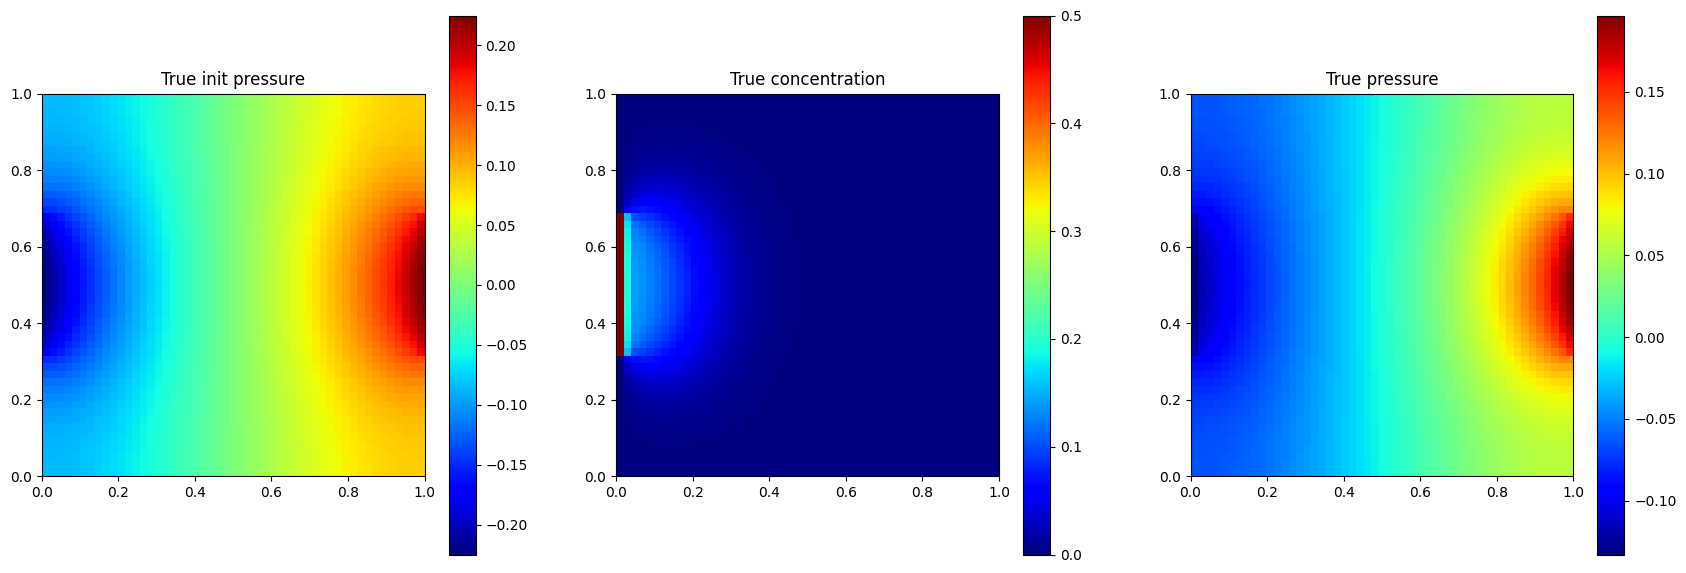

In [32]:
fig = plt.figure(figsize=(21,7))
plt.subplot(131)
vis.plot(solver.p[0], [x_min,x_max,y_min,y_max], 'True init pressure')
plt.subplot(132)
vis.plot(solver.c[-1], [x_min,x_max,y_min,y_max], 'True concentration')
plt.subplot(133)
vis.plot(solver.p[-1], [x_min,x_max,y_min,y_max], 'True pressure')

-0.002629444


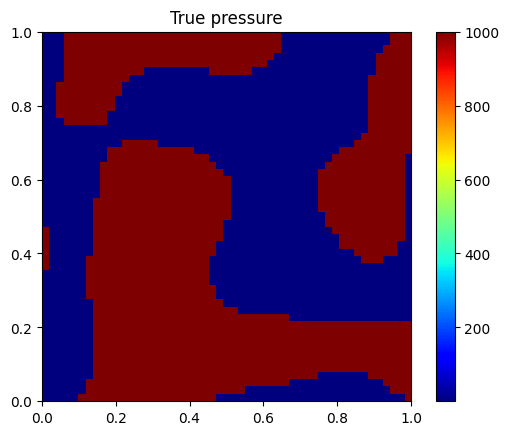

In [168]:
a = np.where(outputs[2]<0, 1000, outputs[2])
print(np.min(outputs[2]))
vis.plot(a, [x_min,x_max,y_min,y_max], 'True pressure')